In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

import westworld
from westworld.assets import *
from westworld.colors import *
from westworld.objects import *
from westworld.agents import *
from westworld.environment import *
from westworld.simulation import *
from westworld.logger import Logger

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


##### References
- https://medium.com/analytics-vidhya/simulating-the-solar-system-with-under-100-lines-of-python-code-5c53b3039fc6
- http://www.petercollingridge.co.uk/tutorials/pygame-physics-simulation/
- https://github.com/apisarenco/naive-n-body-sim/blob/master/main.py
- http://www.cs.ucy.ac.cy/~ppapap01/nbody/Presentation.pdf

##### Ideas
- Switch to vector fields (with speed and position vector), maybe useful to define gravitational fields, or direction fields in mobility simulations
- Add eating behavior where planets colliding forms bigger planets, but super big planets exploding
- Visualize force fields with heatmaps

##### TODO
- Add option to visualize in the notebook without saving to video
- Circle collides does not work right now

# Playground

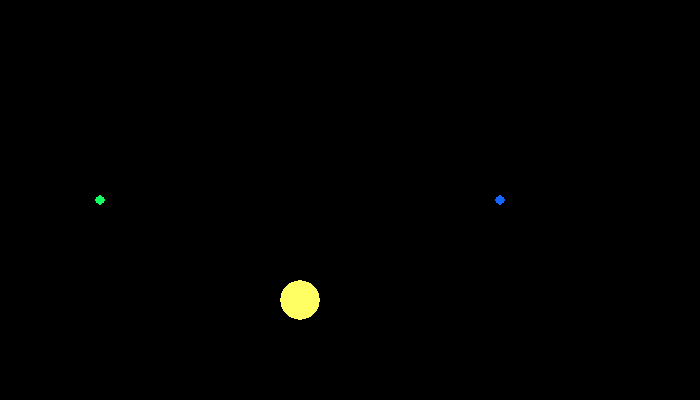

In [176]:
G = 10


class Planet(BaseAgent):
    
    def __init__(self,x,y,mass,radius,mobile = True,*args,**kwargs):
        
        self.mass = mass
        self.mobile = mobile
        self._radius = radius
        
        self.r = np.array([x,y],dtype = np.float32)
        self.v = np.array([0,0],dtype = np.float32)
        self.a = np.array([0,0],dtype = np.float32)


        super().__init__(x,y,*args,**kwargs,circle = True,width = radius*2,height = radius*2,collision_method = "circle")
        
    @property
    def blocking(self):
        return True
    
    
    def calculate_acceleration(self):
        
        a = np.array([0,0],dtype = np.float32)
        
        for planet in self.env.objects:
            
            if planet.id != self.id:
            
                r = planet.r - self.r
                a_planet = (G * planet.mass * r) / (np.sum(r**2)**(3./2))
                a += a_planet
            
        return a

    
    
    def step_euler(self,dt):
        
#         if self.mass < 500:
#             print(self.a[0],self.v[0],self.r[0])
# #         print("sun" if self.mass > 20 else "earth"," ->", self.a,self.v,self.r)
        
        self.r += self.v * dt # Forward euler pass
        self.a = self.calculate_acceleration()
        self.v += self.a * dt  # Backward euler pass (acceleration is updated)
    
    
    def step(self):
        
        if self.mobile:

            self.step_euler(1)
            x = int(self.r[0])
            y = int(self.r[1])
            self.move_at(x,y)
            
    def when_blocked(self,collisions):
        if self.mobile:
            self.kill()
            self.env.finish_episode()
        
    
sun = Planet(350,200,mass = 100,radius = 30,color = (255,205,66),mobile = False)
earth = Planet(500,200,mass = 10,radius = 5,color = (20,100,255))
earth2 = Planet(100,200,mass = 20,radius = 5,color = (20,255,100))
earth3 = Planet(300,300,mass = 100,radius = 20,color = (255,255,100))



earth.v += np.array([0,2])
earth2.v += np.array([0,-1])
earth3.v += np.array([0.5,-0.5])

class Space(SpatialEnvironment):
    
    def compute_reward(self):
        return 1
    
    
    def post_step(self):
        self.is_out()
    
    def is_out(self):
        for obj in self.objects:
            x,y = obj.x,obj.y
            if x < 0 or y < 0 or x > self.width or y > self.height:
                self.finish_episode()


env = Space(width = 700,height = 400,objects = [earth,earth2,earth3],toroidal = False)
env.render()
env.get_img()

In [177]:
sim = Simulation(env,fps = 50)
sim.run_episode(n_steps = 1000,replay = True,fps_replay = 25,render = False)

156

# Reinforcement Learning for orbit stability

In [178]:
import optuna

In [179]:
study = optuna.create_study(direction= "maximize")

In [180]:
def objective(trial):

    earth = Planet(500,200,mass = 10,radius = 5,color = (20,100,255))
    earth2 = Planet(100,200,mass = 20,radius = 5,color = (20,255,100))
    earth3 = Planet(300,300,mass = 100,radius = 20,color = (255,255,100))
    
    for i,p in enumerate([earth,earth2,earth3]):
        vx = trial.suggest_uniform(f"vx{i}",-2,2)
        vy = trial.suggest_uniform(f"vy{i}",-2,2)
        
        p.v += np.array([vx,vy])
    


    env = Space(width = 700,height = 400,objects = [earth,earth2,earth3],toroidal = False)
    sim = Simulation(env,fps = 50)
    reward = sim.run_episode(n_steps = 1000,replay = True,fps_replay = 25,render = False)
    return reward

In [181]:
study.optimize(objective,n_trials = 100)

[I 2020-07-17 23:22:40,089] Finished trial#0 with value: 53.0 with parameters: {'vx0': -0.3206415270003049, 'vy0': 1.0459996163251368, 'vx1': -0.5162635144364986, 'vy1': 1.0873301258598773, 'vx2': 1.8849903367549525, 'vy2': -0.13832558677967643}. Best is trial#0 with value: 53.0.


[I 2020-07-17 23:22:41,282] Finished trial#1 with value: 81.0 with parameters: {'vx0': -0.8906705879024588, 'vy0': 1.6254209658541092, 'vx1': 1.5666228746816957, 'vy1': 0.7700729345938861, 'vx2': -0.7527441761380529, 'vy2': 1.1917948892727797}. Best is trial#1 with value: 81.0.


[I 2020-07-17 23:22:42,498] Finished trial#2 with value: 58.0 with parameters: {'vx0': -1.0094472975611, 'vy0': -0.8054697888153814, 'vx1': 1.3625869233739283, 'vy1': -0.5577797397464002, 'vx2': 1.0112018710081587, 'vy2': -1.650362431747379}. Best is trial#1 with value: 81.0.


[I 2020-07-17 23:22:43,762] Finished trial#3 with value: 124.0 with parameters: {'vx0': -0.676090010992541, 'vy0': -0.04739770011267863, 'vx1': -0.644158021964532, 'vy1': 1.798777964899485, 'vx2': -1.589261066175689, 'vy2': -0.8238509876284366}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:44,844] Finished trial#4 with value: 57.0 with parameters: {'vx0': 1.5588619100225491, 'vy0': 0.5272116429008498, 'vx1': -1.3415972535308813, 'vy1': -0.096830723957118, 'vx2': -1.4545056781985375, 'vy2': 1.8623725004420342}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:45,929] Finished trial#5 with value: 55.0 with parameters: {'vx0': -1.643107410220904, 'vy0': 1.1615739927806037, 'vx1': 0.140325309732368, 'vy1': -1.1465315806071108, 'vx2': -0.8249273014392422, 'vy2': 1.9388539257162485}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:47,170] Finished trial#6 with value: 59.0 with parameters: {'vx0': -0.6725721475092161, 'vy0': -0.14011323155173505, 'vx1': 1.2660428533974382, 'vy1': 0.06829120587867665, 'vx2': 1.0432894992348425, 'vy2': -1.2736478009314967}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:48,345] Finished trial#7 with value: 77.0 with parameters: {'vx0': -0.31864761887698423, 'vy0': 0.32627478294278367, 'vx1': -1.8889545622609067, 'vy1': 1.6323843298091139, 'vx2': -0.14392932972577688, 'vy2': 1.4053403251937309}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:49,436] Finished trial#8 with value: 61.0 with parameters: {'vx0': 1.2443692799521076, 'vy0': 0.32935828614801554, 'vx1': 0.6023391114618608, 'vy1': 0.16313733469125813, 'vx2': -1.8864853788465945, 'vy2': 1.791158735799149}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:50,644] Finished trial#9 with value: 96.0 with parameters: {'vx0': 0.6318754256704135, 'vy0': -1.1560258002412462, 'vx1': 1.666413310430808, 'vy1': -1.2610753757351132, 'vx2': 0.8015263712554428, 'vy2': -0.7570892701116949}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:51,901] Finished trial#10 with value: 72.0 with parameters: {'vx0': -1.823280801647205, 'vy0': -1.7722958682481567, 'vx1': -0.7730523336518207, 'vy1': 1.9022724610058515, 'vx2': -1.817116745202978, 'vy2': 0.1541043853084818}. Best is trial#3 with value: 124.0.


[I 2020-07-17 23:22:53,315] Finished trial#11 with value: 140.0 with parameters: {'vx0': 0.7535021100223098, 'vy0': -1.4192857885877697, 'vx1': -0.565618367315971, 'vy1': -1.877307830543803, 'vx2': 0.8217280527702614, 'vy2': -0.6222680776517211}. Best is trial#11 with value: 140.0.


[I 2020-07-17 23:22:54,576] Finished trial#12 with value: 125.0 with parameters: {'vx0': 0.3005667588360329, 'vy0': -1.9722912148409057, 'vx1': -0.7926866488707927, 'vy1': -1.9157041934789232, 'vx2': 1.848943659704474, 'vy2': -0.5170503735443599}. Best is trial#11 with value: 140.0.


[I 2020-07-17 23:22:55,807] Finished trial#13 with value: 110.0 with parameters: {'vx0': 0.4568344571558719, 'vy0': -1.978609457713567, 'vx1': -1.4059001507246622, 'vy1': -1.9220418841077143, 'vx2': 1.9767038636878849, 'vy2': 0.2360582637672562}. Best is trial#11 with value: 140.0.


[I 2020-07-17 23:22:57,055] Finished trial#14 with value: 138.0 with parameters: {'vx0': 0.7652326801762827, 'vy0': -1.3827925192070538, 'vx1': -0.052314447101680275, 'vy1': -1.902207377792705, 'vx2': 1.47640808102245, 'vy2': -0.4648729282205606}. Best is trial#11 with value: 140.0.


[I 2020-07-17 23:22:58,407] Finished trial#15 with value: 226.0 with parameters: {'vx0': 1.0122977568391986, 'vy0': -1.2288054375424031, 'vx1': 0.27238979051432094, 'vy1': -1.4053764160252613, 'vx2': 0.5262736440409108, 'vy2': 0.6821716715138992}. Best is trial#15 with value: 226.0.


[I 2020-07-17 23:23:00,000] Finished trial#16 with value: 280.0 with parameters: {'vx0': 1.900768652416407, 'vy0': -0.6217798500443764, 'vx1': 0.6782824204909244, 'vy1': -1.338896941164302, 'vx2': 0.3422410626749806, 'vy2': 0.7020784844139067}. Best is trial#16 with value: 280.0.


[I 2020-07-17 23:23:01,429] Finished trial#17 with value: 224.0 with parameters: {'vx0': 1.9749387742232405, 'vy0': -0.5779019009396084, 'vx1': 0.7810868156754427, 'vy1': -1.1600671188151812, 'vx2': 0.15064823777180678, 'vy2': 0.6686444264400034}. Best is trial#16 with value: 280.0.


[I 2020-07-17 23:23:02,778] Finished trial#18 with value: 169.0 with parameters: {'vx0': 1.9307449400993075, 'vy0': -0.7188719965226286, 'vx1': 0.8050152998404582, 'vy1': -0.6374592898731352, 'vx2': 0.1675674341421767, 'vy2': 0.8769001274769215}. Best is trial#16 with value: 280.0.


[I 2020-07-17 23:23:04,375] Finished trial#19 with value: 268.0 with parameters: {'vx0': 1.283085635355475, 'vy0': -0.4256026700555268, 'vx1': 0.2504110017583236, 'vy1': -1.3224128805029314, 'vx2': -0.3425948747880272, 'vy2': 0.7206217641758791}. Best is trial#16 with value: 280.0.


[I 2020-07-17 23:23:05,613] Finished trial#20 with value: 103.0 with parameters: {'vx0': 1.537390819399413, 'vy0': -0.3846193632589149, 'vx1': 1.9552626936864765, 'vy1': -0.6631571669393879, 'vx2': -0.4772087300582684, 'vy2': 1.2356017235072616}. Best is trial#16 with value: 280.0.


[I 2020-07-17 23:23:07,409] Finished trial#21 with value: 323.0 with parameters: {'vx0': 1.2692032855725124, 'vy0': -1.1317008397626076, 'vx1': 0.25634307364206893, 'vy1': -1.5073320353813164, 'vx2': 0.4927439350109799, 'vy2': 0.697284184345232}. Best is trial#21 with value: 323.0.


[I 2020-07-17 23:23:09,207] Finished trial#22 with value: 364.0 with parameters: {'vx0': 1.573091251072705, 'vy0': -0.3524279546237549, 'vx1': -0.11186421756836588, 'vy1': -1.5135349699567877, 'vx2': -0.24807773990663873, 'vy2': 0.42331480635715363}. Best is trial#22 with value: 364.0.


[I 2020-07-17 23:23:11,015] Finished trial#23 with value: 391.0 with parameters: {'vx0': 1.9728648285347978, 'vy0': -0.9646494132821826, 'vx1': -0.0787021049269388, 'vy1': -1.6358477568042118, 'vx2': 0.4186762626029921, 'vy2': 0.33782159804052203}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:12,815] Finished trial#24 with value: 326.0 with parameters: {'vx0': 1.673145123965923, 'vy0': -1.038625748646912, 'vx1': -0.2021666222578894, 'vy1': -1.636140200625732, 'vx2': 0.505130781162892, 'vy2': 0.36091775967615464}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:14,050] Finished trial#25 with value: 110.0 with parameters: {'vx0': 1.7020797329473316, 'vy0': -0.9642662581706715, 'vx1': -0.2611910391352801, 'vy1': -0.8951051557371561, 'vx2': -0.97228986827528, 'vy2': -0.12408118125695144}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:15,466] Finished trial#26 with value: 158.0 with parameters: {'vx0': 1.962303735096781, 'vy0': -1.6157007193754538, 'vx1': -1.0754530068470611, 'vy1': -1.6319483760373792, 'vx2': 1.4359759120403952, 'vy2': 0.34346857283126864}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:16,843] Finished trial#27 with value: 201.0 with parameters: {'vx0': 1.6409151923101255, 'vy0': -0.24069942615562012, 'vx1': -0.20259124451809774, 'vy1': -1.6748308779777907, 'vx2': -0.059465314204561026, 'vy2': -0.17611772838490886}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:18,046] Finished trial#28 with value: 118.0 with parameters: {'vx0': 1.0353224989613794, 'vy0': -0.8985510380935201, 'vx1': -0.28762635386900137, 'vy1': -0.2797711288855764, 'vx2': -0.31414057977245613, 'vy2': 0.14321732245003735}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:19,275] Finished trial#29 with value: 176.0 with parameters: {'vx0': 1.4038771958539893, 'vy0': 0.19269062040994922, 'vx1': -0.3131046023679864, 'vy1': -0.9558211712926946, 'vx2': 0.5370555460061283, 'vy2': 0.4131274710562135}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:20,477] Finished trial#30 with value: 157.0 with parameters: {'vx0': 1.7225083329350217, 'vy0': -1.6304550398984563, 'vx1': 0.4749755136196972, 'vy1': 0.6361935043351854, 'vx2': 1.3387607531976045, 'vy2': -0.1756629070320937}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:21,853] Finished trial#31 with value: 125.0 with parameters: {'vx0': 1.1742631799718635, 'vy0': -1.0867785298810309, 'vx1': 0.006592787626379437, 'vy1': -1.6254042311636725, 'vx2': 0.49502931168696623, 'vy2': 0.9656405345172803}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:23,264] Finished trial#32 with value: 239.0 with parameters: {'vx0': 0.9309690594690646, 'vy0': -1.3510850548980364, 'vx1': 1.0515493560409388, 'vy1': -1.6081664883589102, 'vx2': 0.23178215000764574, 'vy2': 0.45450258047412245}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:24,489] Finished trial#33 with value: 100.0 with parameters: {'vx0': 0.058922021632224375, 'vy0': -0.8946950165582936, 'vx1': 0.326063687523951, 'vy1': -1.0053226904820947, 'vx2': 0.7480280612438801, 'vy2': 1.161686361004384}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:25,526] Finished trial#34 with value: 76.0 with parameters: {'vx0': 1.4297220943761724, 'vy0': -0.4786231585221832, 'vx1': -0.4334401824938971, 'vy1': -1.512862601051615, 'vx2': -0.5685769626629034, 'vy2': 1.43883850499966}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:26,947] Finished trial#35 with value: 173.0 with parameters: {'vx0': 1.79598839089877, 'vy0': -0.7874048403493071, 'vx1': 0.11302904223632515, 'vy1': -1.8039201203200637, 'vx2': 1.1247307722090638, 'vy2': 0.02219501551784009}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:28,596] Finished trial#36 with value: 245.0 with parameters: {'vx0': 1.4595180764477347, 'vy0': -0.004486346546392794, 'vx1': -0.9533325011777463, 'vy1': -0.7937669447384321, 'vx2': -0.0011928913913001882, 'vy2': 0.4403042328655058}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:29,834] Finished trial#37 with value: 86.0 with parameters: {'vx0': 1.9385668888700485, 'vy0': -1.0676822932210004, 'vx1': -0.004100558071137073, 'vy1': -0.5010022349944339, 'vx2': -1.0195033991381615, 'vy2': -0.28763827699220096}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:31,125] Finished trial#38 with value: 146.0 with parameters: {'vx0': 1.124884958489909, 'vy0': 0.8670671224931386, 'vx1': 0.4237236505789001, 'vy1': -1.9908276489968633, 'vx2': 0.39852717927994175, 'vy2': 0.8637117619166361}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:32,347] Finished trial#39 with value: 118.0 with parameters: {'vx0': 1.6417498647168212, 'vy0': -0.16876202941859797, 'vx1': -0.4908805539355821, 'vy1': -1.097501800274915, 'vx2': -0.1609322238487288, 'vy2': -1.9816289257686543}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:33,549] Finished trial#40 with value: 108.0 with parameters: {'vx0': 1.271395872139139, 'vy0': 1.909598411790101, 'vx1': 0.998926165629805, 'vy1': -1.4686711921720392, 'vx2': 0.6886315941266843, 'vy2': -1.1075665834258925}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:35,161] Finished trial#41 with value: 259.0 with parameters: {'vx0': 1.8356791230016805, 'vy0': -0.5639667235933952, 'vx1': 0.6056419579570553, 'vy1': -1.32096398260832, 'vx2': 0.29607365558754917, 'vy2': 0.59386955210643}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:36,394] Finished trial#42 with value: 107.0 with parameters: {'vx0': 1.9360743322180216, 'vy0': -0.6310053552477378, 'vx1': -0.08391309894336445, 'vy1': -1.2909077288882398, 'vx2': 0.9867564866426612, 'vy2': 1.068769329403024}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:37,596] Finished trial#43 with value: 74.0 with parameters: {'vx0': -1.3429769811846612, 'vy0': -0.30241371217134305, 'vx1': 0.6093074315821383, 'vy1': -1.7570973954809421, 'vx2': 0.08261956292533884, 'vy2': 1.5009608644566172}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:38,838] Finished trial#44 with value: 114.0 with parameters: {'vx0': 1.5326374040129076, 'vy0': -0.7483972690899543, 'vx1': 0.14019286081773857, 'vy1': 0.3121507813434943, 'vx2': 0.3438303967110823, 'vy2': 0.08209910012654127}. Best is trial#23 with value: 391.0.


[I 2020-07-17 23:23:41,099] Finished trial#45 with value: 491.0 with parameters: {'vx0': 1.7769931796830214, 'vy0': -1.2008700016667253, 'vx1': 0.8658038836417828, 'vy1': -1.9865440811766844, 'vx2': -0.24427744119826872, 'vy2': 0.27006052312031886}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:42,185] Finished trial#46 with value: 55.0 with parameters: {'vx0': -0.4177063688472633, 'vy0': -1.5691067840316326, 'vx1': 1.374814184544948, 'vy1': 1.349875535390164, 'vx2': -0.7367949855027156, 'vy2': 0.2922578534734086}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:43,983] Finished trial#47 with value: 419.0 with parameters: {'vx0': 0.818871662186929, 'vy0': -1.2477820458075497, 'vx1': -0.7087460487009085, 'vy1': -1.7727577871401974, 'vx2': -0.22236304974587995, 'vy2': 0.48308247904582596}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:45,396] Finished trial#48 with value: 172.0 with parameters: {'vx0': 0.8481534190260893, 'vy0': -1.7536089232796237, 'vx1': -0.6876842499214909, 'vy1': -1.9391246997962057, 'vx2': -0.2926074570326498, 'vy2': -0.024832042743248295}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:47,020] Finished trial#49 with value: 241.0 with parameters: {'vx0': 0.5428179061488703, 'vy0': -1.3149924053411028, 'vx1': -1.3427926513971689, 'vy1': -1.8221826552077678, 'vx2': -0.6428554507493505, 'vy2': -0.3726106481197377}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:48,462] Finished trial#50 with value: 170.0 with parameters: {'vx0': 0.25042546722977344, 'vy0': -0.9717954909643473, 'vx1': -1.159291929243927, 'vy1': -1.9990785174039143, 'vx2': -1.2279875487204779, 'vy2': 0.5139247539338352}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:49,912] Finished trial#51 with value: 229.0 with parameters: {'vx0': 1.3155950777087657, 'vy0': -1.4513685209504854, 'vx1': -0.44352912582698834, 'vy1': -1.4565971320983016, 'vx2': -0.1948477993099438, 'vy2': 0.17767082082953922}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:51,202] Finished trial#52 with value: 140.0 with parameters: {'vx0': 1.7515426968329963, 'vy0': -1.2252467857744005, 'vx1': -0.7969728488508568, 'vy1': -1.150407565475546, 'vx2': -0.4605574574627135, 'vy2': 0.8886959704518577}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:52,673] Finished trial#53 with value: 218.0 with parameters: {'vx0': 1.093445276284173, 'vy0': -1.0684599595467927, 'vx1': -0.1692805149546494, 'vy1': -1.7255848515952912, 'vx2': 0.6440994000245275, 'vy2': 0.2845223351360866}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:53,893] Finished trial#54 with value: 126.0 with parameters: {'vx0': 0.736828609312134, 'vy0': -1.795956307650164, 'vx1': -0.5714189366027085, 'vy1': -1.9981892389510898, 'vx2': 0.9081091032620631, 'vy2': 0.7696195784357626}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:55,683] Finished trial#55 with value: 319.0 with parameters: {'vx0': 1.5317030698099223, 'vy0': -1.1914185771010708, 'vx1': 0.9019139402327147, 'vy1': -1.5665300094622245, 'vx2': -0.06342890116849298, 'vy2': 0.5814826740431197}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:56,758] Finished trial#56 with value: 74.0 with parameters: {'vx0': 1.3585031881518117, 'vy0': -1.4300149710405239, 'vx1': -1.836045886095645, 'vy1': -1.4609359826820285, 'vx2': 0.056999066542888, 'vy2': -0.03172597088498741}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:58,000] Finished trial#57 with value: 134.0 with parameters: {'vx0': 1.5901051418758883, 'vy0': 0.18596588629357907, 'vx1': 0.4385136998402569, 'vy1': -1.776512751577207, 'vx2': 1.209910250385125, 'vy2': 0.2873536694313916}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:23:59,974] Finished trial#58 with value: 419.0 with parameters: {'vx0': 1.8001999422314867, 'vy0': -0.8512318282509073, 'vx1': 0.17456982006307098, 'vy1': -1.0934830917463074, 'vx2': 0.19036051241804464, 'vy2': 0.5814751606204008}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:24:01,414] Finished trial#59 with value: 212.0 with parameters: {'vx0': 1.826144466922877, 'vy0': -0.8809410323728062, 'vx1': 1.7482682018342557, 'vy1': -1.2129313077577726, 'vx2': -0.38563972140614944, 'vy2': 0.5509836228730596}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:24:02,982] Finished trial#60 with value: 318.0 with parameters: {'vx0': 1.9905741159788672, 'vy0': -0.6806736367965933, 'vx1': -0.3767268635946267, 'vy1': -1.6950195587140267, 'vx2': 0.17001302894016987, 'vy2': 0.1978270625289919}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:24:04,391] Finished trial#61 with value: 204.0 with parameters: {'vx0': 1.6635996973110712, 'vy0': -1.0320237456079284, 'vx1': 0.19950515049785744, 'vy1': -1.394878884037215, 'vx2': 0.46925649267050956, 'vy2': 0.7546392144959767}. Best is trial#45 with value: 491.0.


[I 2020-07-17 23:24:06,556] Finished trial#62 with value: 656.0 with parameters: {'vx0': 1.204315617724324, 'vy0': -1.268852721959651, 'vx1': 0.07430205735278633, 'vy1': -1.561070341043338, 'vx2': -0.21491115526694532, 'vy2': 0.39620701877523085}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:08,014] Finished trial#63 with value: 200.0 with parameters: {'vx0': 1.4297184003340115, 'vy0': -1.5394849133281725, 'vx1': -0.1071111983105485, 'vy1': -1.8964004276594926, 'vx2': -0.20158673826346907, 'vy2': 0.4374839635621166}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:09,467] Finished trial#64 with value: 193.0 with parameters: {'vx0': 0.9811141700654543, 'vy0': -1.2791264508885474, 'vx1': -0.22474297999706921, 'vy1': -1.0774340506313864, 'vx2': -0.06658573581248797, 'vy2': 0.3720611266681577}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:10,992] Finished trial#65 with value: 219.0 with parameters: {'vx0': 1.1988714086069505, 'vy0': -0.7727357309795062, 'vx1': 0.06576777196823645, 'vy1': -1.6732805412700191, 'vx2': 0.2213863221413015, 'vy2': 0.0959066538921668}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:12,258] Finished trial#66 with value: 141.0 with parameters: {'vx0': 1.7805356406972668, 'vy0': -0.5161133495056555, 'vx1': 1.2620417598890392, 'vy1': -1.2417517761521948, 'vx2': -0.5838878538862126, 'vy2': 0.994293604164324}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:13,751] Finished trial#67 with value: 151.0 with parameters: {'vx0': 1.5400306891805746, 'vy0': -1.7587824765786229, 'vx1': 0.37836301076719137, 'vy1': -0.8418668124653824, 'vx2': -0.2508241208443658, 'vy2': 0.6121034695041827}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:15,174] Finished trial#68 with value: 173.0 with parameters: {'vx0': 0.9021673311900623, 'vy0': -0.3385853969258785, 'vx1': -0.6261123721374283, 'vy1': -1.5795599341117301, 'vx2': -0.7863203452548464, 'vy2': -0.18027479753879655}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:16,532] Finished trial#69 with value: 169.0 with parameters: {'vx0': 1.9915361264921003, 'vy0': -0.9288569605097842, 'vx1': 0.011668256985305214, 'vy1': -1.7953396968173407, 'vx2': -0.4566087202189223, 'vy2': 0.3684249604648726}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:17,976] Finished trial#70 with value: 158.0 with parameters: {'vx0': 1.7011422026043874, 'vy0': -1.2236525155328566, 'vx1': -0.344677230891277, 'vy1': -1.3708072648027643, 'vx2': 0.08636931106604817, 'vy2': 0.8228783438352003}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:19,705] Finished trial#71 with value: 354.0 with parameters: {'vx0': 1.2815732494013403, 'vy0': -1.140341846565566, 'vx1': 0.27039458463335175, 'vy1': -1.5365498994910867, 'vx2': 0.6171733936446937, 'vy2': 0.6379472969735531}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:21,337] Finished trial#72 with value: 245.0 with parameters: {'vx0': 1.3541921868902094, 'vy0': -1.142306868596186, 'vx1': 0.5123664664123602, 'vy1': -1.5416551897736057, 'vx2': 0.3951811925591504, 'vy2': 0.20451778510802202}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:22,752] Finished trial#73 with value: 214.0 with parameters: {'vx0': 1.1523088718823917, 'vy0': -1.4947849201212149, 'vx1': 0.30712976263812186, 'vy1': -1.868676516212629, 'vx2': 0.6357992398446982, 'vy2': 0.5071704890469426}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:23,999] Finished trial#74 with value: 138.0 with parameters: {'vx0': 1.8643420854899104, 'vy0': -1.3517410052504737, 'vx1': 0.16521398536975673, 'vy1': -1.9909225258896663, 'vx2': 0.8685377160589578, 'vy2': 0.6611725469226672}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:25,275] Finished trial#75 with value: 86.0 with parameters: {'vx0': 0.6879532946634662, 'vy0': -0.8388480546801893, 'vx1': -0.15511236390787272, 'vy1': -1.63956121284853, 'vx2': 0.5721874582861123, 'vy2': 1.288965327007227}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:26,678] Finished trial#76 with value: 183.0 with parameters: {'vx0': 1.5020239955207093, 'vy0': -0.996002672629279, 'vx1': 0.7763207036416736, 'vy1': -0.9950222581085061, 'vx2': -0.09824309025987979, 'vy2': 0.46874222641479324}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:27,907] Finished trial#77 with value: 131.0 with parameters: {'vx0': 1.2524597519536662, 'vy0': -1.875182063065605, 'vx1': -0.031389703356331955, 'vy1': -0.33899587933172504, 'vx2': 0.27927417239215024, 'vy2': 0.007322140728458937}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:29,138] Finished trial#78 with value: 122.0 with parameters: {'vx0': 1.0450050944016014, 'vy0': -1.1150237737000444, 'vx1': -0.9074490004881954, 'vy1': -1.3941859189334247, 'vx2': 0.03755378781892715, 'vy2': 0.9672901388732049}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:30,580] Finished trial#79 with value: 142.0 with parameters: {'vx0': 0.8175295819774318, 'vy0': -1.6399134644352664, 'vx1': 0.12786536884275007, 'vy1': -1.280845245568884, 'vx2': -0.34686541575495733, 'vy2': -0.08437019013301988}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:31,873] Finished trial#80 with value: 106.0 with parameters: {'vx0': 1.6351763658973595, 'vy0': -0.4375505306845897, 'vx1': 0.5217782472126895, 'vy1': -1.5155589120832629, 'vx2': 0.17786328079166203, 'vy2': 1.1026526776437495}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:33,273] Finished trial#81 with value: 227.0 with parameters: {'vx0': 1.3859652362936086, 'vy0': -1.3684975355763478, 'vx1': 0.051168295286072696, 'vy1': -1.6822377084335942, 'vx2': 0.7598000096124393, 'vy2': 0.7004834837734131}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:35,103] Finished trial#82 with value: 387.0 with parameters: {'vx0': 0.371574890215237, 'vy0': -1.1791766511137074, 'vx1': 0.2646425945682495, 'vy1': -1.8556431169314327, 'vx2': 0.3066673298141822, 'vy2': 0.2981327960888092}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:37,476] Finished trial#83 with value: 501.0 with parameters: {'vx0': 0.2907522716478166, 'vy0': -1.2709201829624854, 'vx1': 0.2482479940931963, 'vy1': -1.8331000161901285, 'vx2': 0.47883160373865147, 'vy2': 0.3193661888980362}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:39,308] Finished trial#84 with value: 422.0 with parameters: {'vx0': -0.009185146299976965, 'vy0': -1.3110061330469174, 'vx1': 0.28480043016516826, 'vy1': -1.8780702118801367, 'vx2': -0.13412184877417327, 'vy2': 0.1251915073429205}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:40,930] Finished trial#85 with value: 347.0 with parameters: {'vx0': -0.10140205945377338, 'vy0': -1.2645966365494883, 'vx1': 0.7114445654266746, 'vy1': -1.8881277838570112, 'vx2': -0.16294241598848613, 'vy2': 0.07923433324956677}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:42,196] Finished trial#86 with value: 172.0 with parameters: {'vx0': 0.35240084894462664, 'vy0': -1.4192432702344775, 'vx1': 0.3631976097489682, 'vy1': -1.7685532706612028, 'vx2': -0.03530845154774104, 'vy2': 0.2545363137076765}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:43,680] Finished trial#87 with value: 193.0 with parameters: {'vx0': 0.12204194886268574, 'vy0': -1.6870874707831356, 'vx1': 0.22488905477279159, 'vy1': -1.859264663527723, 'vx2': -0.4042370885610077, 'vy2': -0.3251571690280362}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:44,969] Finished trial#88 with value: 81.0 with parameters: {'vx0': -0.3297636284802292, 'vy0': -1.5349915384246673, 'vx1': -1.7050989319854177, 'vy1': -1.9895032331140845, 'vx2': 0.3771045074534607, 'vy2': 0.1326499099305613}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:46,239] Finished trial#89 with value: 152.0 with parameters: {'vx0': -0.10968539654295134, 'vy0': -0.6620467980200992, 'vx1': 1.188531552015783, 'vy1': -1.7555453718718952, 'vx2': -0.5295040073976647, 'vy2': -0.23554522364702982}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:47,659] Finished trial#90 with value: 218.0 with parameters: {'vx0': 0.43494495267342437, 'vy0': -0.8348649157646628, 'vx1': 0.5450393830417863, 'vy1': -1.996421605217138, 'vx2': -0.2520618607888406, 'vy2': 0.3616308000480779}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:50,079] Finished trial#91 with value: 605.0 with parameters: {'vx0': 0.23754748024812544, 'vy0': -1.1638484875699013, 'vx1': 0.2704710638957591, 'vy1': -1.581840986000293, 'vx2': 0.1051524668874253, 'vy2': 0.5115343912024009}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:51,913] Finished trial#92 with value: 334.0 with parameters: {'vx0': 0.2352371065668192, 'vy0': -1.2857521299060473, 'vx1': 0.6415320598159104, 'vy1': -1.8352610921519958, 'vx2': 0.08500063414072406, 'vy2': 0.5002444213519806}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:53,578] Finished trial#93 with value: 316.0 with parameters: {'vx0': 0.5765337485449977, 'vy0': -1.1890590908142928, 'vx1': -0.06386706026888259, 'vy1': -1.6269288459146456, 'vx2': 0.1311210099397927, 'vy2': 0.25454594841726297}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:55,187] Finished trial#94 with value: 259.0 with parameters: {'vx0': 0.1107998979693276, 'vy0': -0.9416869996045993, 'vx1': 0.384646852266359, 'vy1': -1.45809980787564, 'vx2': 0.28543810818640686, 'vy2': 0.40199916787097595}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:56,806] Finished trial#95 with value: 240.0 with parameters: {'vx0': -0.11417413968873677, 'vy0': -1.0380693987778944, 'vx1': 0.19274633631453064, 'vy1': -1.909202565861804, 'vx2': -0.1241801138713865, 'vy2': 0.5693081206487768}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:58,237] Finished trial#96 with value: 210.0 with parameters: {'vx0': 0.40845438564560665, 'vy0': -1.4469929779867685, 'vx1': 0.8991021799794696, 'vy1': -1.717153973979587, 'vx2': 0.45864582478805005, 'vy2': 0.30700047563633465}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:24:59,859] Finished trial#97 with value: 207.0 with parameters: {'vx0': 0.16732673977349735, 'vy0': -1.339337939873237, 'vx1': 0.05930566298007947, 'vy1': -1.5780483145318203, 'vx2': -0.6557504825729883, 'vy2': -0.09459254283700269}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:25:01,093] Finished trial#98 with value: 117.0 with parameters: {'vx0': -0.011524915677286418, 'vy0': 0.5469268635260895, 'vx1': 0.3081297666391441, 'vy1': -1.3968257635252868, 'vx2': 0.012484779196886009, 'vy2': 0.8031527648037537}. Best is trial#62 with value: 656.0.


[I 2020-07-17 23:25:02,533] Finished trial#99 with value: 179.0 with parameters: {'vx0': 0.5542181346295152, 'vy0': -1.0931573220494404, 'vx1': -0.24741387288862665, 'vy1': -1.8043078746712402, 'vx2': 0.28335108923725905, 'vy2': 0.03598342841918034}. Best is trial#62 with value: 656.0.


In [184]:
v = study.best_params

In [186]:
earth = Planet(500,200,mass = 10,radius = 5,color = (20,100,255))
earth2 = Planet(100,200,mass = 20,radius = 5,color = (20,255,100))
earth3 = Planet(300,300,mass = 100,radius = 20,color = (255,255,100))

earth.v += np.array([v["vx0"],v["vy0"]])
earth2.v += np.array([v["vx1"],v["vy1"]])
earth3.v += np.array([v["vx2"],v["vy2"]])

env = Space(width = 700,height = 400,objects = [earth,earth2,earth3],toroidal = False)
sim = Simulation(env,fps = 50)
reward = sim.run_episode(n_steps = 1000,replay = True,fps_replay = 25,render = True,save = True)

[INFO] Saving video at ./captures/Simulation_1595021306.mp4



interactive(children=(Play(value=0, description='Press play', interval=40, max=656), Output()), _dom_classes=(…

IntSlider(value=0, max=656)

# Other tests

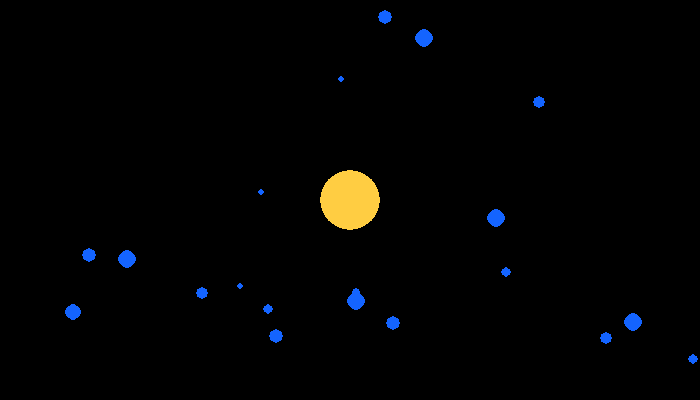

In [199]:
G = 10


class Planet(BaseAgent):
    
    def __init__(self,x,y,mass,radius,mobile = True,*args,**kwargs):
        
        self.mass = mass
        self.mobile = mobile
        self._radius = radius
        
        self.r = np.array([x,y],dtype = np.float32)
        self.v = np.array([0,0],dtype = np.float32)
        self.a = np.array([0,0],dtype = np.float32)


        super().__init__(x,y,*args,**kwargs,circle = True,width = radius*2,height = radius*2,collision_method = "circle")
        
    @property
    def blocking(self):
        return False
    
    
    def calculate_acceleration(self):
        
        a = np.array([0,0],dtype = np.float32)
        
        for planet in self.env.objects:
            
            if planet.id != self.id:
            
                r = planet.r - self.r
                a_planet = (G * planet.mass * r) / (np.sum(r**2)**(3./2))
                a += a_planet
            
        return a

    
    
    def step_euler(self,dt):
        
#         if self.mass < 500:
#             print(self.a[0],self.v[0],self.r[0])
# #         print("sun" if self.mass > 20 else "earth"," ->", self.a,self.v,self.r)
        
        self.r += self.v * dt # Forward euler pass
        self.a = self.calculate_acceleration()
        self.v += self.a * dt  # Backward euler pass (acceleration is updated)
    
    
    def step(self):
        
        if self.mobile:

            self.step_euler(1)
            x = int(self.r[0])
            y = int(self.r[1])
            self.move_at(x,y)
            
    def when_blocked(self,collisions):
        if self.mobile:
            self.kill()
            self.env.finish_episode()
        
    
sun = Planet(350,200,mass = 100,radius = 30,color = (255,205,66),mobile = False)
spawner = lambda x,y: Planet(x,y,mass = np.random.randint(10,30),radius = np.random.randint(2,10),color = (20,100,255))

class Space(SpatialEnvironment):
    
    def compute_reward(self):
        return 1
    
    
    def post_step(self):
        pass
    
    def is_out(self):
        for obj in self.objects:
            x,y = obj.x,obj.y
            if x < 0 or y < 0 or x > self.width or y > self.height:
                self.finish_episode()


env = Space(width = 700,height = 400,objects = [sun],toroidal = False)
env.spawn(spawner,20,allow_overlap = True)

for item in env.objects:
    item.v += np.random.randn(2) / 5
    
env.render()
env.get_img()

In [200]:
sim = Simulation(env,fps = 50)
reward = sim.run_episode(n_steps = 100,replay = True,fps_replay = 25,render = True,save = True)

[INFO] Saving video at ./captures/Simulation_1595021704.mp4



interactive(children=(Play(value=0, description='Press play', interval=40), Output()), _dom_classes=('widget-i…

IntSlider(value=0)